In [29]:
from typing import List, Tuple
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
import spacy
from datasets import load_dataset

In [30]:
def load_sib200_ru() -> Tuple[Tuple[List[str], List[int]], Tuple[List[str], List[int]], Tuple[List[str], List[int]], List[str]]:
    trainset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='train')
    X_train = trainset['text']
    y_train = trainset['category']
    valset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='validation')
    X_val = valset['text']
    y_val = valset['category']
    testset = load_dataset('Davlan/sib200', 'rus_Cyrl', split='test')
    X_test = testset['text']
    y_test = testset['category']
    categories = set(y_train)
    unknown_categories = set(y_val) - categories
    if len(unknown_categories) > 0:
        err_msg = f'The categories {unknown_categories} are represented in the validation set, but they are not represented in the training set.'
        raise RuntimeError(err_msg)
    unknown_categories = set(y_test) - categories
    if len(unknown_categories) > 0:
        err_msg = f'The categories {unknown_categories} are represented in the test set, but they are not represented in the training set.'
        raise RuntimeError(err_msg)
    categories = sorted(list(categories))
    y_train = [categories.index(it) for it in y_train]
    y_val = [categories.index(it) for it in y_val]
    y_test = [categories.index(it) for it in y_test]
    return (X_train, y_train), (X_val, y_val), (X_test, y_test), categories

train_data, val_data, test_data, classes_list = load_sib200_ru()
print(f'Categories: {classes_list}')

Categories: ['entertainment', 'geography', 'health', 'politics', 'science/technology', 'sports', 'travel']


In [31]:
nlp = spacy.load('ru_core_news_sm')

def normalize_text(s: str, nlp_pipeline: spacy.Language) -> str:
    doc = nlp_pipeline(s)
    lemmas = [('<NUM>' if token.like_num else token.lemma_.lower()) for token in doc if not token.is_punct]
    return ' '.join(lemmas) if lemmas else ''

In [ ]:
classifier = Pipeline(steps=[
    ('vectorizer', TfidfVectorizer(
        token_pattern=r'(?u)\b\w\w+\b', 
        max_df=1.0 - 0.2 / len(classes_list),
        min_df=1
    )),
    ('cls', LogisticRegression(solver='saga', max_iter=1000, random_state=42))  # ← 1000
])

cv = GridSearchCV(
    estimator=classifier,
    param_grid={
        'vectorizer__ngram_range': [(1, 1), (1, 2)],
        'cls__C': [0.1, 1, 10, 100],
        'cls__penalty': ['l1', 'l2']
    },
    scoring='f1_macro',
    cv=5,
    refit=True,
    n_jobs=-1,
    verbose=0
)

X_train_norm = [normalize_text(it, nlp) for it in train_data[0]]
cv.fit(X_train_norm, train_data[1])

print('Best parameters (GridSearch):')
print(cv.best_params_)
print('Best F1-macro (CV):', cv.best_score_)

y_pred_val = cv.predict([normalize_text(it, nlp) for it in val_data[0]])
f1_val_gs = f1_score(val_data[1], y_pred_val, average='macro')
print('F1-macro (val, GridSearch):', f1_val_gs)

Best parameters (GridSearch):
{'cls__C': 100, 'cls__penalty': 'l2', 'vectorizer__ngram_range': (1, 1)}
Best F1-macro (CV): 0.6365454550262191
F1-macro (val, GridSearch): 0.6835794548720985


In [33]:
final_model = Pipeline([
    ('vectorizer', TfidfVectorizer(
        token_pattern=r'(?u)\b\w\w+\b',
        ngram_range=(1, 1),
        max_df=0.90,
        min_df=1,
        sublinear_tf=True,
        stop_words=None
    )),
    ('cls', LogisticRegression(
        solver='saga', C=3, penalty='l2',
        class_weight='balanced', max_iter=1000, random_state=42
    ))
])

final_model.fit(X_train_norm, train_data[1])
y_pred_val_final = final_model.predict([normalize_text(it, nlp) for it in val_data[0]])
f1_val_final = f1_score(val_data[1], y_pred_val_final, average='macro')
print('F1-macro (val, final model):', f1_val_final)

F1-macro (val, final model): 0.7015823913300877


In [34]:
X_train_full = list(train_data[0]) + list(val_data[0])
y_train_full = list(train_data[1]) + list(val_data[1])
X_train_full_norm = [normalize_text(it, nlp) for it in X_train_full]

final_model.fit(X_train_full_norm, y_train_full)
y_pred_test = final_model.predict([normalize_text(it, nlp) for it in test_data[0]])
f1_test = f1_score(test_data[1], y_pred_test, average='macro')
print('F1-macro (test, final model on train+val):', f1_test)

F1-macro (test, final model on train+val): 0.7022347951462192


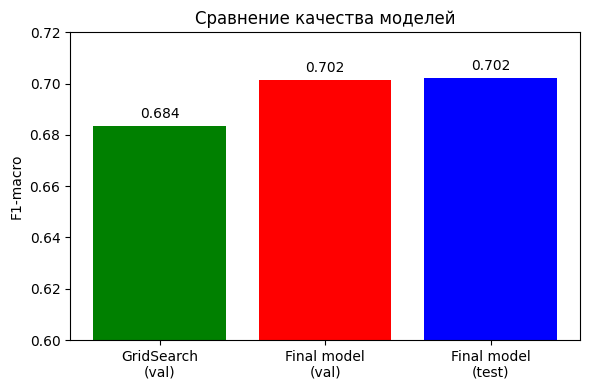

In [37]:
# %%
stages = ['GridSearch\n(val)', 'Final model\n(val)', 'Final model\n(test)']
f1s = [f1_val_gs, f1_val_final, f1_test]

plt.figure(figsize=(6, 4))
bars = plt.bar(stages, f1s, color=['green', 'red', 'blue'])
plt.ylabel('F1-macro')
plt.title('Сравнение качества моделей')
plt.ylim(0.6, 0.72)
for bar, score in zip(bars, f1s):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.003, f'{score:.3f}', ha='center')
plt.tight_layout()
plt.show()

In [36]:
print("\n=== Итоговый отчёт (тест) ===")
print(classification_report(test_data[1], y_pred_test, target_names=classes_list))


=== Итоговый отчёт (тест) ===
                    precision    recall  f1-score   support

     entertainment       0.77      0.53      0.62        19
         geography       0.75      0.53      0.62        17
            health       0.65      0.59      0.62        22
          politics       0.75      0.80      0.77        30
science/technology       0.76      0.76      0.76        51
            sports       0.79      0.88      0.83        25
            travel       0.62      0.75      0.68        40

          accuracy                           0.72       204
         macro avg       0.73      0.69      0.70       204
      weighted avg       0.72      0.72      0.72       204

